## 따릉이 대여량 예측 경진대회(DACON)

### 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


### 변수 탐색

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 21.5+ KB


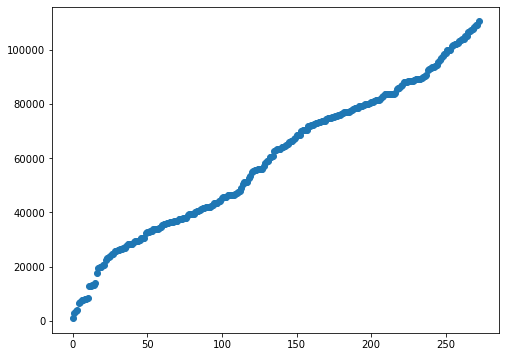

In [3]:
# 이상치 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['number_of_rentals'].values))
plt.show()

In [4]:
# date_time 날짜 변수를 datetime으로 바꾸기 -> 년/월/일 추출

train['date_time'] = pd.to_datetime(train['date_time'])
test['date_time'] = pd.to_datetime(test['date_time'])

train['day']=pd.DatetimeIndex(train['date_time']).day
test['day']=pd.DatetimeIndex(test['date_time']).day
train['month']=pd.DatetimeIndex(train['date_time']).month
test['month']=pd.DatetimeIndex(test['date_time']).month
train['year']=pd.DatetimeIndex(train['date_time']).year
test['year']=pd.DatetimeIndex(test['date_time']).year
train['weekday']=pd.DatetimeIndex(train['date_time']).weekday
test['weekday']=pd.DatetimeIndex(test['date_time']).weekday

321.622

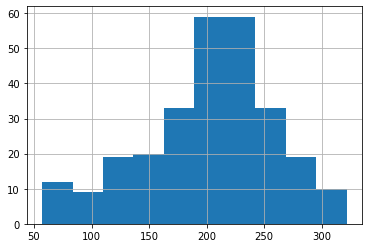

In [5]:
# wind_direction 풍향 변수 확인
# 풍향은 자전거 대여에 유의미한 변수가 아니라고 판단

train['wind_direction'].hist()
train['wind_direction'].max()

In [6]:
# 비가 오는 상황을 예측하는 두 변수 precipitation_form와 Precipitation_Probability간 상관관계는 높음
train['precipitation_form'].corr(train['Precipitation_Probability'])

0.9106089542607185

In [7]:
# 일일 강우 단기예측 기록인 precipitation_form 변수가 하루 비가 오는 날을 더 잘 표현
# 비슷한 부분을 설명하는 두 변수이기 때문에 precipitation_form 변수만 사용
train['precipitation_form'].corr(train['sky_condition'])

0.6738137525457336

<BarContainer object of 91 artists>

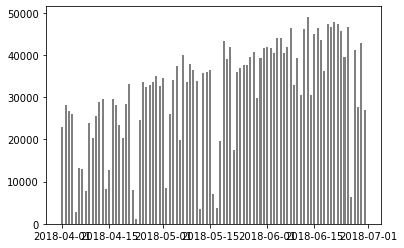

In [8]:
import matplotlib.pyplot as plt

plt.bar(train['date_time'][train['year'] == 2018], train['number_of_rentals'][train['year'] == 2018], width=0.6, color='grey')

In [9]:
# 따릉이 대여량을 2018년 기준으로 날짜순으로 확인
# (5월 2일 => 32일, 6월 10일 => 30일 + 31일 + 10일 = 71일)


train['day'][train['month'] == 5] += 30
train['day'][train['month'] == 6] += 61

test['day'][test['month'] == 5] += 30
test['day'][test['month'] == 6] += 61

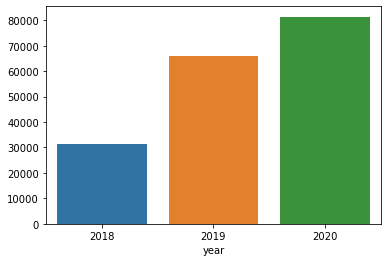

In [10]:
# 연도별 따릉이 이용자수
# 시간이 지날수록 이용자수가 증가하는 것을 보아 연도 변수는 매우 중요

import seaborn as sns

def barplots(variable):
    plot = train.groupby(variable)['number_of_rentals'].mean()
    sns.barplot(plot.index,plot.values)
barplots('year')

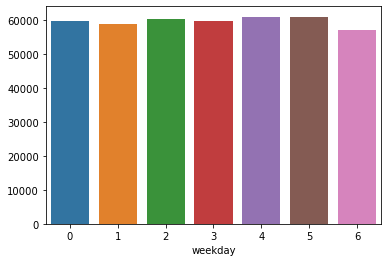

In [11]:
# 요일별 이용자수
# 0은 월요일, 6은 일요일을 나타내는 요일 변수
barplots('weekday')

In [12]:
# 유의미하지 않는 변수 제거

train_label = train['number_of_rentals']
train.drop(['date_time','wind_direction', 'Precipitation_Probability', 'month', 'number_of_rentals'], axis = 1, inplace= True)
test.drop(['date_time','wind_direction', 'Precipitation_Probability', 'month'], axis = 1, inplace= True)

### 모델 적합

In [14]:
# 랜덤포레스트 모델 사용

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 0, n_estimators = 100)
rf.fit(train,train_label)
sample_submission['number_of_rentals'] = rf.predict(test)
sample_submission.to_csv('bicycle_final_4.csv',encoding='UTF-8',index=False)